# Importing packages

In [16]:
import torch
import numpy as np
import lightning as L

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../transforms/')
sys.path.append('../TFC_Configs/')
sys.path.append('../models/')
sys.path.append('../data_modules/')
sys.path.append('../best_results/')

from config_files.TFC_Configs import *
from transforms.tfc_augmentations import *
from transforms.tfc_utils import set_seed, plot_backbone_metrics, plot_head_metrics
from models.tfc import *
from data_modules.uci_4_tfc import *
from best_results.HAR.tfc_pretrain import *
from best_results.HAR.tfc_train import load_pretrained_backbone, build_downstream_datamodule, build_downstream_model

In [19]:
set_seed(42)

In [20]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'Times New Roman',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# IMPORTANT INSTRUCTIONS

In this specific notebook, we add the floor term to the cross-space loss. Inside the folder `models/tfc.py, class TFC_Backbone.` there will be a function called `compute_backbone_combined_loss`. Here, you must uncomment the line:

- loss_consistency = torch.clamp(loss_consistency, min=0.0)

And comment all print debug statements present in this function

With this done, you may run the notebook normally

# 1.0 Loading Pretext Task DataLoader

In [21]:
# Configuration files that contains all hyperparameters to be used in the training (model, data, optimizer, loss, etc)

batch_size = 64
global_config_file = GlobalConfigFile(batch_size=batch_size) 

In [22]:
pretext_datamodule = build_pretext_datamodule(global_config_file=global_config_file, 
                                              batch_size=batch_size,
                                              root_data_dir='../data/uci/preprocessed/')

# 2.0 Understanding the Augmentations That Where Applied

In [23]:
example_module = UCIDataModule_4_TFC(root_data_dir='../data/uci/preprocessed/', # Data was preprocessed using the notebook/tf_c/1_ETL_UCI_WISDM, and then saved to this directory
                           batch_size=batch_size,
                           flatten=False,
                           target_column='class',
                           training_mode='TFC', # The specific transformations for TFC are done if this is set to 'TFC'
                           transform=False)     # No transformations for the example module

In [24]:
example_train_uci = example_module.train_dataloader()

loader_iter = iter(example_train_uci)
first_batch = next(iter(example_train_uci))

df, target = first_batch

We will sample unique classes to better visualize the differences. We have 6 batches with 6 sensors and 60 time steps. Each batch has a unique label

In [25]:
selected_data, unique_classes = sample_unique_classes(df, target)

print("Filtered Dataframe Shape:", selected_data.shape)
print("Unique Classes:", unique_classes)

Filtered Dataframe Shape: torch.Size([6, 6, 60])
Unique Classes: tensor([0, 1, 2, 3, 4, 5])


## 2.1 Time Augmentations

Each augmentation has their specific hyperparameters. For this study, we will use the default ones

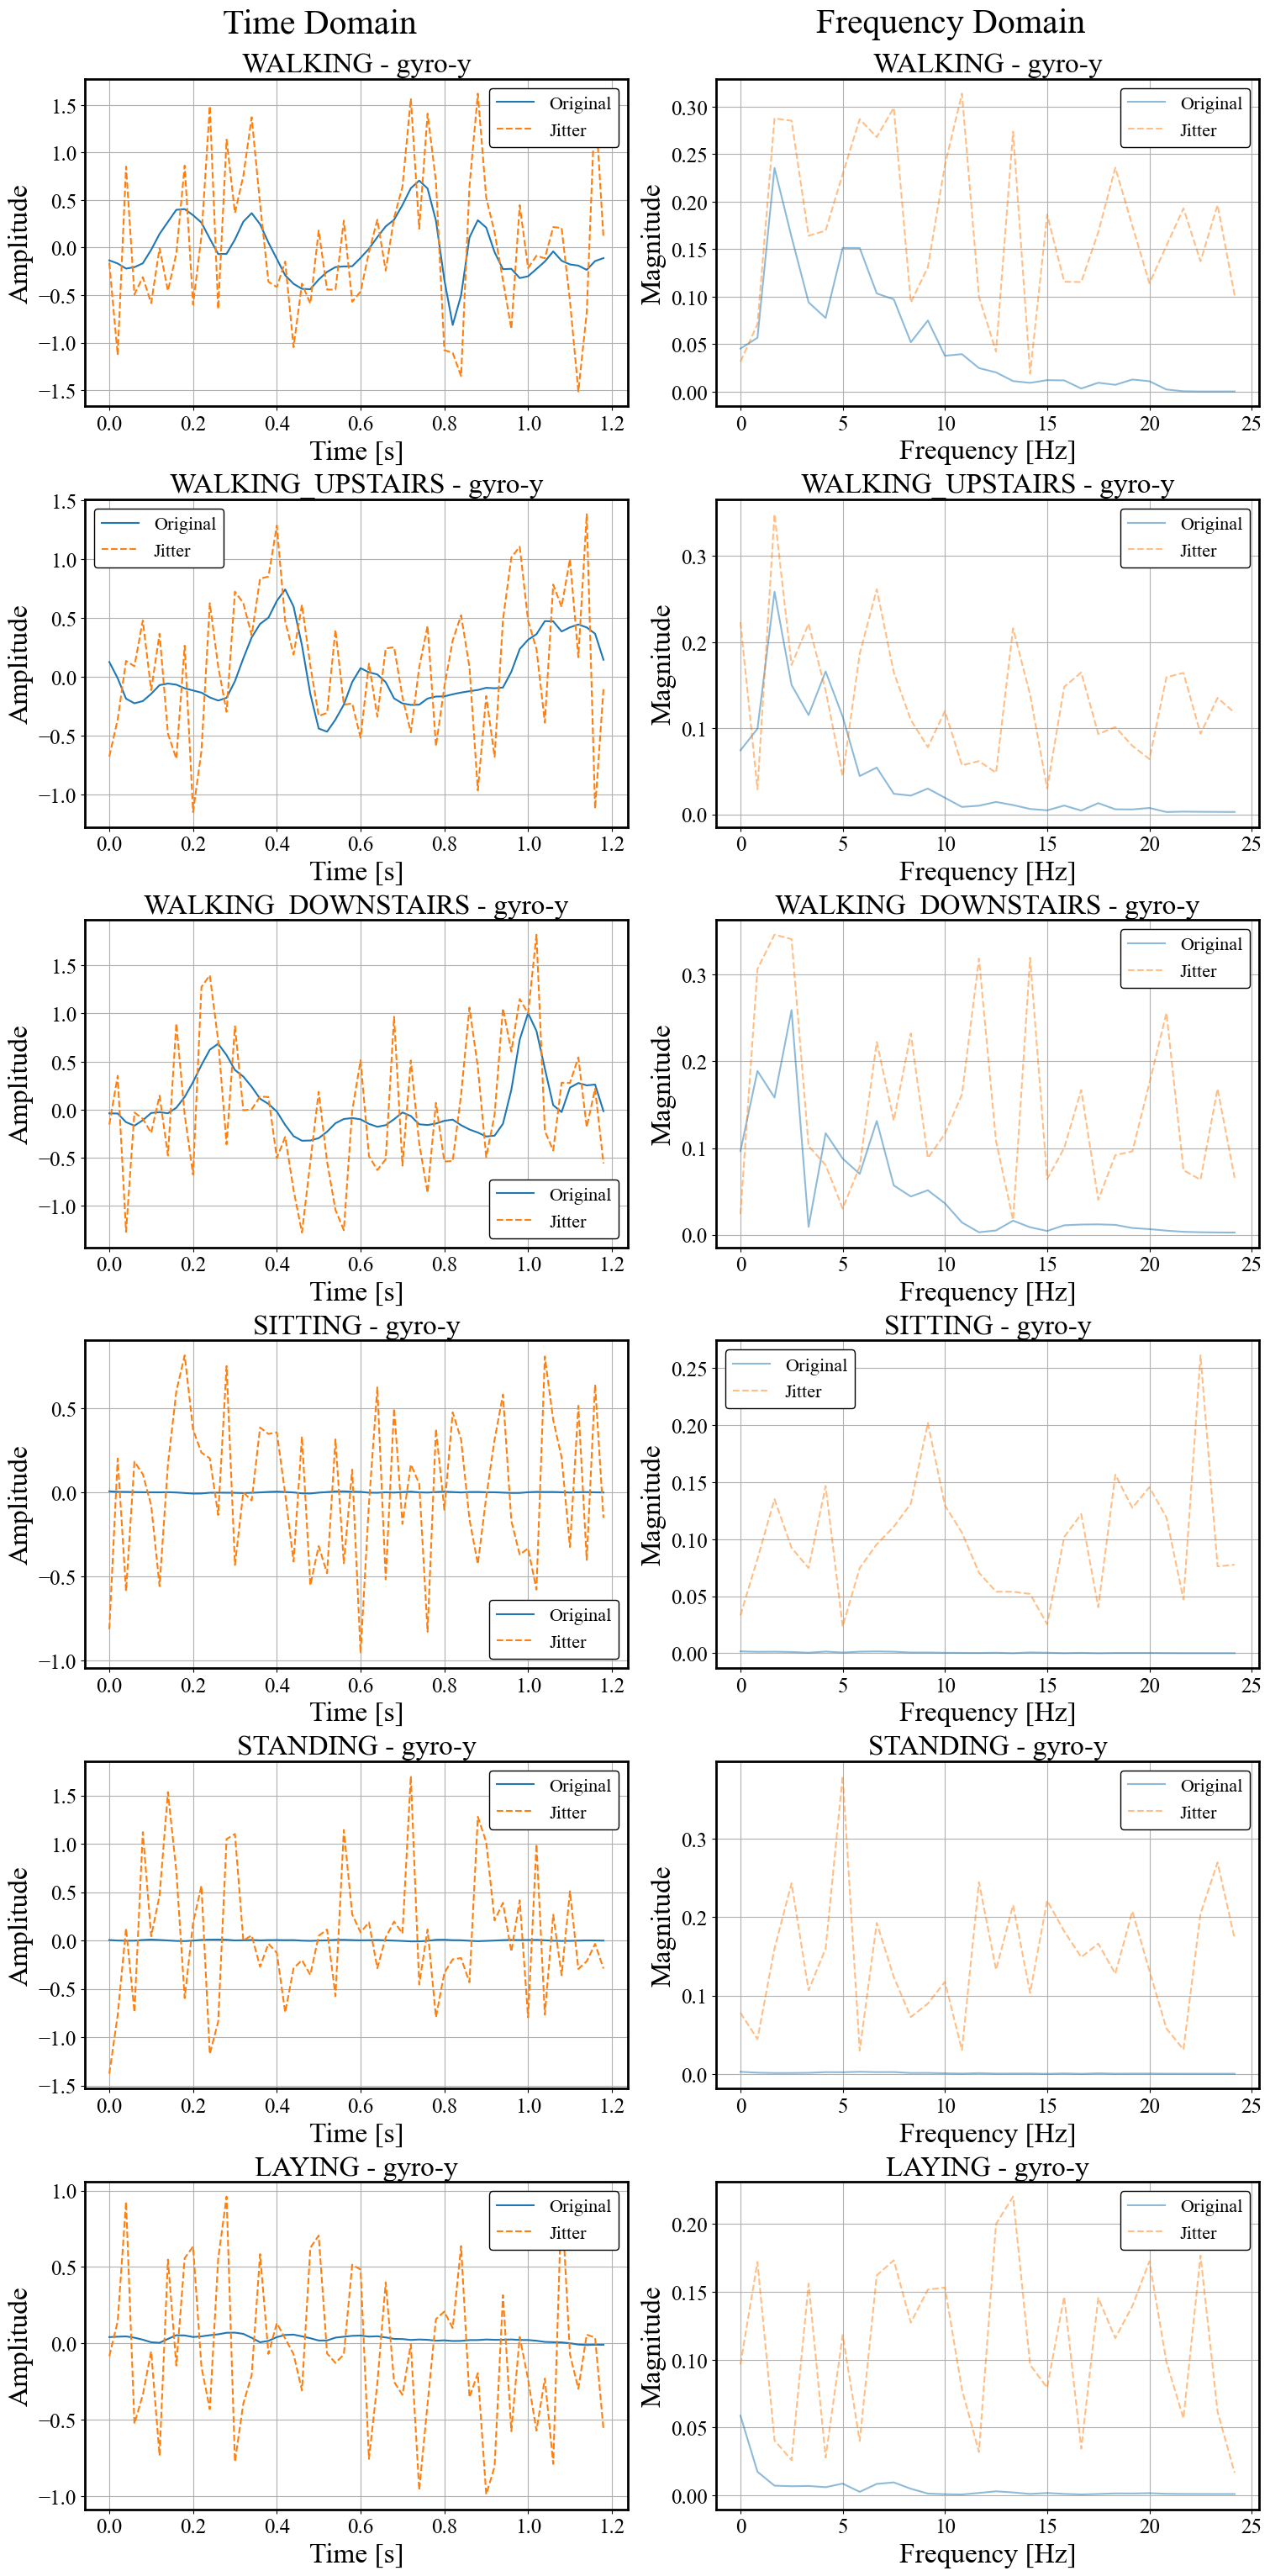

In [26]:
aug_time_and_plot_time_and_frequency_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               sensors = ['gyro-y'],
                               operation='jitter', # 'jitter', 'scaling', 'permutation', 'masking' 
                               )

## 2.2 Frequency Augmentations

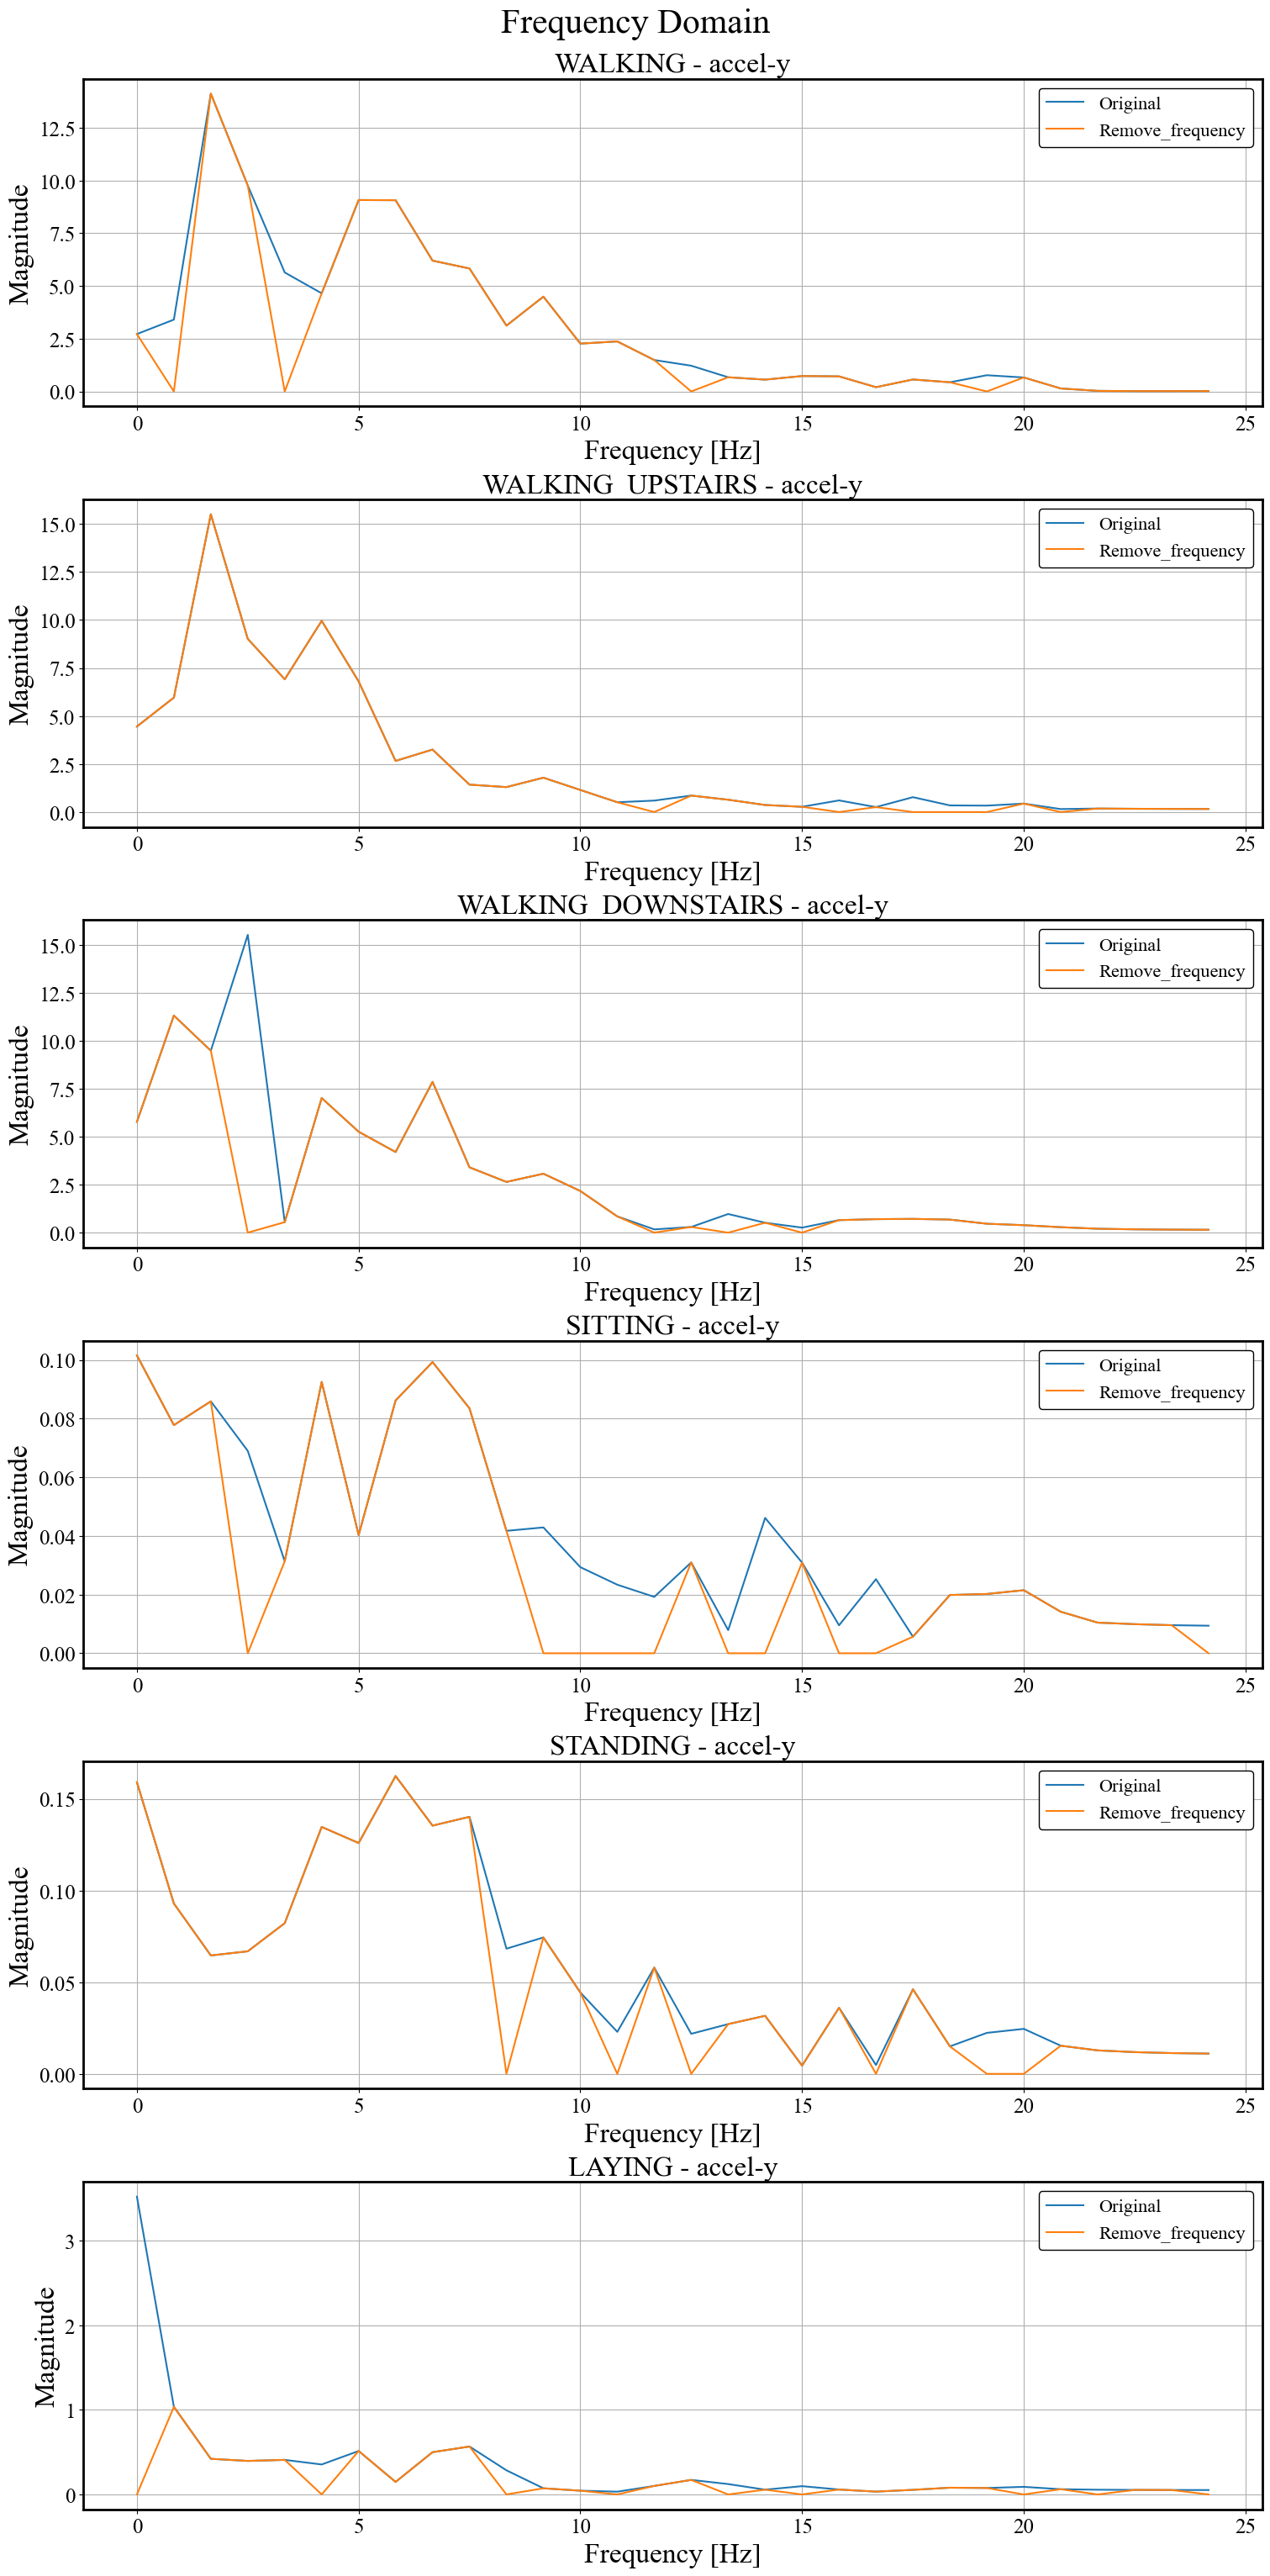

In [27]:
aug_freq_and_plot_freq_time_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               sensors = ['accel-y'],
                               operation='remove_frequency', # 'remove_frequency', 'add_frequency', 'both'
                               remove_ratio=0.2, # Hyperparameter for the operation
                               perturb_ratio=0.1, # Hyperparameter for the operation
                               )

# 3.0 Creating the Pretext Class Training Loop

Here we will train `ONLY` the Backbone without any label information. 

In [28]:
pretext_model = build_pretext_model(global_config_file)
SSL_technique_prefix = 'TF_C'

In [29]:
# Initializing parameters to name the experiment and the version
log_dir = "lightning_logs"
experiment_name = SSL_technique_prefix

pretext_lightning_trainer, experiment_path = build_lightning_trainer(log_dir=log_dir, 
                                                                 experiment_name=experiment_name, 
                                                                 verbose=True,
                                                                 version='Pretext',
                                                                 max_epochs=40, # High number of epochs so that the patience causes the stopping
                                                                 min_delta=0.005,
                                                                 patience=5,
                                                                 monitor='train_loss_total',
                                                                 SSL_technique_prefix=SSL_technique_prefix)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


From experience and when my PC didn't overheat, going over 100 epochs produces the best results with min_delta = 0.005. We are using 40 here due to hardware limitations

Fitting the model

In [30]:
pretext_lightning_trainer.fit(pretext_model, pretext_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | nt_xent_criterion | NTXentLoss | 0     
1 | conv_block1_t     | Sequential | 1.6 K 
2 | conv_block2_t     | Sequential | 16.5 K
3 | conv_block3_t     | Sequential | 3.1 K 
4 | conv_block1_f     | Sequential | 1.6 K 
5 | conv_block2_f     | Sequential | 16.5 K
6 | conv_block3_f     | Sequential | 3.1 K 
7 | projector_t       | Sequential | 38.3 K
8 | projector_f       | Sequential | 38.3 K
-------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.476     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 193/193 [00:55<00:00,  3.48it/s, val_loss_total=2.770, val_loss_time_enc=6.060, val_loss_freq_enc=7.770, val_loss_consist=0.000, train_loss_total=6.120, train_loss_time_enc=7.910, train_loss_freq_enc=10.40, train_loss_consist=3.070]

Metric train_loss_total improved. New best score: 6.115


Epoch 1: 100%|██████████| 193/193 [00:37<00:00,  5.14it/s, val_loss_total=2.180, val_loss_time_enc=5.470, val_loss_freq_enc=5.340, val_loss_consist=0.0184, train_loss_total=2.360, train_loss_time_enc=5.680, train_loss_freq_enc=5.700, train_loss_consist=0.105]

Metric train_loss_total improved by 3.756 >= min_delta = 0.005. New best score: 2.359


Epoch 2: 100%|██████████| 193/193 [00:36<00:00,  5.23it/s, val_loss_total=2.050, val_loss_time_enc=5.200, val_loss_freq_enc=5.060, val_loss_consist=0.000, train_loss_total=2.230, train_loss_time_enc=5.350, train_loss_freq_enc=5.640, train_loss_consist=0.0407]

Metric train_loss_total improved by 0.129 >= min_delta = 0.005. New best score: 2.231


Epoch 3: 100%|██████████| 193/193 [00:37<00:00,  5.15it/s, val_loss_total=2.000, val_loss_time_enc=5.140, val_loss_freq_enc=4.850, val_loss_consist=0.000, train_loss_total=2.120, train_loss_time_enc=5.250, train_loss_freq_enc=5.200, train_loss_consist=0.0366]

Metric train_loss_total improved by 0.112 >= min_delta = 0.005. New best score: 2.119


Epoch 4: 100%|██████████| 193/193 [00:37<00:00,  5.17it/s, val_loss_total=2.220, val_loss_time_enc=5.550, val_loss_freq_enc=5.570, val_loss_consist=0.000, train_loss_total=2.040, train_loss_time_enc=5.080, train_loss_freq_enc=4.910, train_loss_consist=0.0543]

Metric train_loss_total improved by 0.076 >= min_delta = 0.005. New best score: 2.043


Epoch 6: 100%|██████████| 193/193 [00:33<00:00,  5.75it/s, val_loss_total=1.910, val_loss_time_enc=4.880, val_loss_freq_enc=4.660, val_loss_consist=0.000, train_loss_total=2.020, train_loss_time_enc=4.910, train_loss_freq_enc=4.690, train_loss_consist=0.131] 

Metric train_loss_total improved by 0.020 >= min_delta = 0.005. New best score: 2.023


Epoch 7: 100%|██████████| 193/193 [00:33<00:00,  5.76it/s, val_loss_total=1.860, val_loss_time_enc=4.720, val_loss_freq_enc=4.590, val_loss_consist=0.000, train_loss_total=1.930, train_loss_time_enc=4.850, train_loss_freq_enc=4.780, train_loss_consist=0.000]

Metric train_loss_total improved by 0.097 >= min_delta = 0.005. New best score: 1.926


Epoch 8: 100%|██████████| 193/193 [00:33<00:00,  5.70it/s, val_loss_total=2.820, val_loss_time_enc=4.470, val_loss_freq_enc=4.230, val_loss_consist=1.350, train_loss_total=1.800, train_loss_time_enc=4.610, train_loss_freq_enc=4.370, train_loss_consist=0.000]

Metric train_loss_total improved by 0.130 >= min_delta = 0.005. New best score: 1.796


Epoch 12: 100%|██████████| 193/193 [00:33<00:00,  5.73it/s, val_loss_total=3.600, val_loss_time_enc=4.280, val_loss_freq_enc=4.090, val_loss_consist=2.410, train_loss_total=1.700, train_loss_time_enc=4.290, train_loss_freq_enc=4.210, train_loss_consist=0.000] 

Metric train_loss_total improved by 0.096 >= min_delta = 0.005. New best score: 1.700


Epoch 13: 100%|██████████| 193/193 [00:33<00:00,  5.72it/s, val_loss_total=7.950, val_loss_time_enc=4.080, val_loss_freq_enc=3.810, val_loss_consist=7.960, train_loss_total=1.610, train_loss_time_enc=4.150, train_loss_freq_enc=3.920, train_loss_consist=0.000]

Metric train_loss_total improved by 0.086 >= min_delta = 0.005. New best score: 1.614


Epoch 15: 100%|██████████| 193/193 [00:33<00:00,  5.77it/s, val_loss_total=4.500, val_loss_time_enc=3.850, val_loss_freq_enc=3.600, val_loss_consist=3.760, train_loss_total=1.520, train_loss_time_enc=3.920, train_loss_freq_enc=3.670, train_loss_consist=0.000] 

Metric train_loss_total improved by 0.095 >= min_delta = 0.005. New best score: 1.520


Epoch 19: 100%|██████████| 193/193 [00:33<00:00,  5.74it/s, val_loss_total=1.480, val_loss_time_enc=3.810, val_loss_freq_enc=3.540, val_loss_consist=0.0152, train_loss_total=1.480, train_loss_time_enc=3.810, train_loss_freq_enc=3.600, train_loss_consist=0.000]

Metric train_loss_total improved by 0.037 >= min_delta = 0.005. New best score: 1.482


Epoch 20: 100%|██████████| 193/193 [00:33<00:00,  5.78it/s, val_loss_total=3.240, val_loss_time_enc=3.670, val_loss_freq_enc=3.340, val_loss_consist=2.300, train_loss_total=1.410, train_loss_time_enc=3.680, train_loss_freq_enc=3.390, train_loss_consist=0.000] 

Metric train_loss_total improved by 0.069 >= min_delta = 0.005. New best score: 1.414


Epoch 22: 100%|██████████| 193/193 [00:33<00:00,  5.75it/s, val_loss_total=1.530, val_loss_time_enc=3.630, val_loss_freq_enc=3.230, val_loss_consist=0.201, train_loss_total=1.380, train_loss_time_enc=3.620, train_loss_freq_enc=3.290, train_loss_consist=0.000]   

Metric train_loss_total improved by 0.030 >= min_delta = 0.005. New best score: 1.384


Epoch 24: 100%|██████████| 193/193 [00:33<00:00,  5.74it/s, val_loss_total=5.430, val_loss_time_enc=3.500, val_loss_freq_enc=3.140, val_loss_consist=5.130, train_loss_total=1.360, train_loss_time_enc=3.580, train_loss_freq_enc=3.210, train_loss_consist=0.000] 

Metric train_loss_total improved by 0.027 >= min_delta = 0.005. New best score: 1.357


Epoch 25: 100%|██████████| 193/193 [00:33<00:00,  5.76it/s, val_loss_total=7.990, val_loss_time_enc=3.490, val_loss_freq_enc=3.030, val_loss_consist=8.360, train_loss_total=1.320, train_loss_time_enc=3.540, train_loss_freq_enc=3.050, train_loss_consist=0.000]

Metric train_loss_total improved by 0.038 >= min_delta = 0.005. New best score: 1.319


Epoch 27: 100%|██████████| 193/193 [00:33<00:00,  5.79it/s, val_loss_total=3.140, val_loss_time_enc=3.450, val_loss_freq_enc=2.950, val_loss_consist=2.330, train_loss_total=1.300, train_loss_time_enc=3.510, train_loss_freq_enc=3.000, train_loss_consist=0.000] 

Metric train_loss_total improved by 0.017 >= min_delta = 0.005. New best score: 1.302


Epoch 29: 100%|██████████| 193/193 [00:33<00:00,  5.76it/s, val_loss_total=6.180, val_loss_time_enc=3.400, val_loss_freq_enc=2.890, val_loss_consist=6.150, train_loss_total=1.270, train_loss_time_enc=3.430, train_loss_freq_enc=2.940, train_loss_consist=0.000]

Metric train_loss_total improved by 0.029 >= min_delta = 0.005. New best score: 1.273


Epoch 30: 100%|██████████| 193/193 [00:33<00:00,  5.75it/s, val_loss_total=6.170, val_loss_time_enc=3.320, val_loss_freq_enc=2.840, val_loss_consist=6.170, train_loss_total=1.240, train_loss_time_enc=3.370, train_loss_freq_enc=2.810, train_loss_consist=0.000]

Metric train_loss_total improved by 0.037 >= min_delta = 0.005. New best score: 1.236


Epoch 35: 100%|██████████| 193/193 [00:33<00:00,  5.78it/s, val_loss_total=7.250, val_loss_time_enc=3.270, val_loss_freq_enc=2.850, val_loss_consist=7.530, train_loss_total=1.250, train_loss_time_enc=3.330, train_loss_freq_enc=2.940, train_loss_consist=0.000] 

Monitored metric train_loss_total did not improve in the last 5 records. Best score: 1.236. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 193/193 [00:33<00:00,  5.78it/s, val_loss_total=7.250, val_loss_time_enc=3.270, val_loss_freq_enc=2.850, val_loss_consist=7.530, train_loss_total=1.250, train_loss_time_enc=3.330, train_loss_freq_enc=2.940, train_loss_consist=0.000]


In [31]:
pretext_save_backbone_weights(pretext_model, experiment_path, SSL_technique_prefix)
print(f"Pretrained weights saved at: {os.path.join(experiment_path, 'pth_files', f'{SSL_technique_prefix}_pretrained_backbone_weights.pth')}")

Saving backbone pretrained weights at lightning_logs/TF_C/Pretext\pth_files\TF_C_pretrained_backbone_weights.pth
Pretrained weights saved at: lightning_logs/TF_C/Pretext\pth_files\TF_C_pretrained_backbone_weights.pth


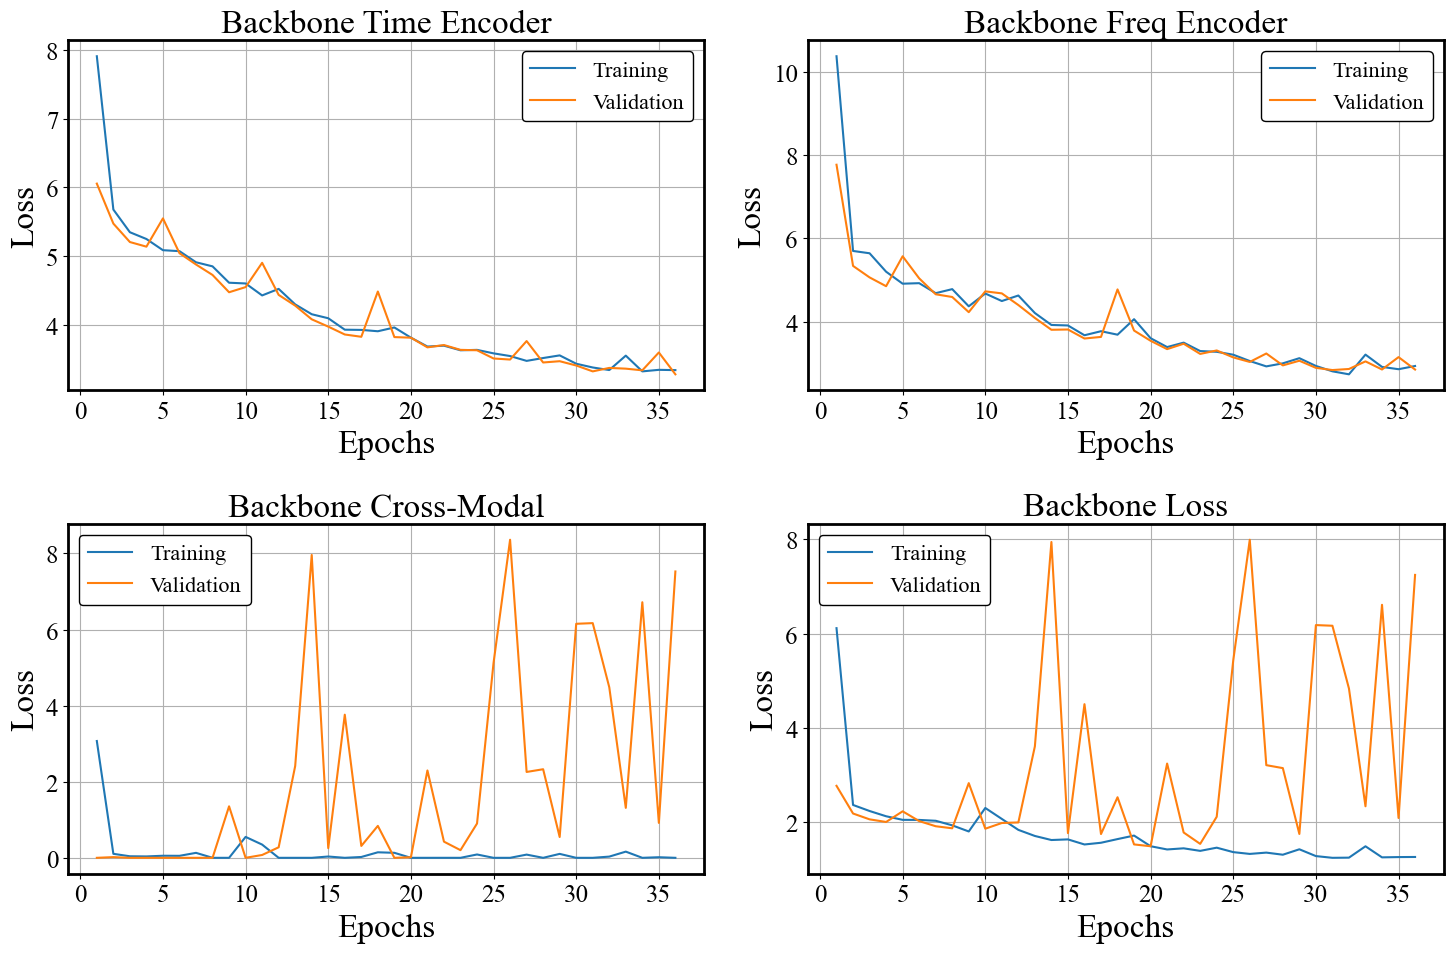

In [32]:
plot_backbone_metrics(pretext_model)

# 4.0 Frozen Backbone + Projection Head

Now that we have the trained backbone, we will freeze it and see if gives good performance on the pretext task. If the performance is good enough, we will be more confident in using it for the downstream task.

Note that the backbone `DID NOT` use label information in its training. What we are doing in this section is more of a sanity check to make sure the backbone actually learning something useful

In [38]:
SSL_technique_prefix = 'TF_C'
pretrain_backbone_output_filename = f"./{log_dir}/{SSL_technique_prefix}/Pretext/pth_files/TF_C_pretrained_backbone_weights.pth"

batch_size = 64
global_config_file = GlobalConfigFile(batch_size=batch_size) 

log_dir = "lightning_logs"
experiment_name = SSL_technique_prefix

In [40]:
backbone = load_pretrained_backbone(pretrain_backbone_output_filename,global_config_file)

# Freezing the backbone
backbone.freeze_weights() 

# Creating pretext frozen backbone + projection head model
frozen_back_bone_with_proj_head = TFC_Combined_Model(backbone = backbone, global_config=global_config_file).to(device)
frozen_back_bone_with_proj_head.freeze_backbone()

In [43]:
pretext_proj_head_lightning_trainer, experiment_path = build_lightning_trainer(log_dir=log_dir, 
                                                    experiment_name=experiment_name, 
                                                    verbose=True,
                                                    version='Pretext_with_Proj_Head',
                                                    max_epochs=40, # High number of epochs so that the patience causes the stopping
                                                    min_delta=0.001,
                                                    patience=20,
                                                    monitor='train_loss_total',
                                                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
pretext_proj_head_lightning_trainer.fit(frozen_back_bone_with_proj_head, pretext_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | backbone        | TFC_Backbone       | 118 K 
1 | projection_head | TFC_Projector_Head | 16.8 K
2 | criterion       | CrossEntropyLoss   | 0     
3 | train_accuracy  | MulticlassAccuracy | 0     
4 | val_accuracy    | MulticlassAccuracy | 0     
5 | train_recall    | MulticlassRecall   | 0     
6 | val_recall      | MulticlassRecall   | 0     
7 | train_f1        | MulticlassF1Score  | 0     
8 | val_f1          | MulticlassF1Score  | 0     
-------------------------------------------------------
16.8 K    Trainable params
118 K     Non-trainable params
135 K     Total params
0.543     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 193/193 [01:01<00:00,  3.16it/s, val_loss_total=8.850, val_accuracy=0.477, val_f1=0.407, train_loss_total=2.640, train_accuracy=0.377, train_f1=0.300]

Metric train_loss_total improved. New best score: 2.637


Epoch 1: 100%|██████████| 193/193 [00:40<00:00,  4.75it/s, val_loss_total=9.950, val_accuracy=0.524, val_f1=0.474, train_loss_total=2.400, train_accuracy=0.497, train_f1=0.457]

Metric train_loss_total improved by 0.233 >= min_delta = 0.001. New best score: 2.405


Epoch 2: 100%|██████████| 193/193 [00:39<00:00,  4.87it/s, val_loss_total=6.390, val_accuracy=0.565, val_f1=0.521, train_loss_total=2.280, train_accuracy=0.545, train_f1=0.526]

Metric train_loss_total improved by 0.121 >= min_delta = 0.001. New best score: 2.284


Epoch 3: 100%|██████████| 193/193 [00:37<00:00,  5.20it/s, val_loss_total=7.790, val_accuracy=0.598, val_f1=0.568, train_loss_total=2.180, train_accuracy=0.585, train_f1=0.571]

Metric train_loss_total improved by 0.099 >= min_delta = 0.001. New best score: 2.185


Epoch 4: 100%|██████████| 193/193 [00:37<00:00,  5.18it/s, val_loss_total=6.060, val_accuracy=0.613, val_f1=0.586, train_loss_total=2.120, train_accuracy=0.606, train_f1=0.604]

Metric train_loss_total improved by 0.062 >= min_delta = 0.001. New best score: 2.123


Epoch 5: 100%|██████████| 193/193 [00:36<00:00,  5.22it/s, val_loss_total=7.270, val_accuracy=0.626, val_f1=0.601, train_loss_total=2.070, train_accuracy=0.620, train_f1=0.617]

Metric train_loss_total improved by 0.048 >= min_delta = 0.001. New best score: 2.075


Epoch 6: 100%|██████████| 193/193 [00:36<00:00,  5.24it/s, val_loss_total=9.760, val_accuracy=0.649, val_f1=0.620, train_loss_total=2.030, train_accuracy=0.623, train_f1=0.619]

Metric train_loss_total improved by 0.043 >= min_delta = 0.001. New best score: 2.032


Epoch 7: 100%|██████████| 193/193 [00:37<00:00,  5.14it/s, val_loss_total=8.330, val_accuracy=0.631, val_f1=0.641, train_loss_total=2.010, train_accuracy=0.637, train_f1=0.633]

Metric train_loss_total improved by 0.019 >= min_delta = 0.001. New best score: 2.013


Epoch 8: 100%|██████████| 193/193 [00:37<00:00,  5.17it/s, val_loss_total=6.450, val_accuracy=0.625, val_f1=0.599, train_loss_total=1.990, train_accuracy=0.644, train_f1=0.641]

Metric train_loss_total improved by 0.026 >= min_delta = 0.001. New best score: 1.987


Epoch 9: 100%|██████████| 193/193 [00:38<00:00,  5.04it/s, val_loss_total=8.240, val_accuracy=0.662, val_f1=0.676, train_loss_total=1.970, train_accuracy=0.643, train_f1=0.641]

Metric train_loss_total improved by 0.020 >= min_delta = 0.001. New best score: 1.967


Epoch 11: 100%|██████████| 193/193 [00:33<00:00,  5.79it/s, val_loss_total=10.10, val_accuracy=0.657, val_f1=0.667, train_loss_total=1.960, train_accuracy=0.649, train_f1=0.655]

Metric train_loss_total improved by 0.006 >= min_delta = 0.001. New best score: 1.960


Epoch 12: 100%|██████████| 193/193 [00:33<00:00,  5.74it/s, val_loss_total=7.040, val_accuracy=0.665, val_f1=0.674, train_loss_total=1.950, train_accuracy=0.655, train_f1=0.661]

Metric train_loss_total improved by 0.014 >= min_delta = 0.001. New best score: 1.947


Epoch 14: 100%|██████████| 193/193 [00:33<00:00,  5.77it/s, val_loss_total=8.200, val_accuracy=0.656, val_f1=0.638, train_loss_total=1.950, train_accuracy=0.662, train_f1=0.667]

Metric train_loss_total improved by 0.002 >= min_delta = 0.001. New best score: 1.945


Epoch 15: 100%|██████████| 193/193 [00:33<00:00,  5.76it/s, val_loss_total=9.130, val_accuracy=0.687, val_f1=0.661, train_loss_total=1.930, train_accuracy=0.661, train_f1=0.669]

Metric train_loss_total improved by 0.020 >= min_delta = 0.001. New best score: 1.925


Epoch 16: 100%|██████████| 193/193 [00:32<00:00,  5.89it/s, val_loss_total=5.210, val_accuracy=0.668, val_f1=0.679, train_loss_total=1.920, train_accuracy=0.672, train_f1=0.680]

Metric train_loss_total improved by 0.004 >= min_delta = 0.001. New best score: 1.921


Epoch 17: 100%|██████████| 193/193 [00:33<00:00,  5.77it/s, val_loss_total=5.830, val_accuracy=0.671, val_f1=0.652, train_loss_total=1.910, train_accuracy=0.667, train_f1=0.677]

Metric train_loss_total improved by 0.007 >= min_delta = 0.001. New best score: 1.914


Epoch 18: 100%|██████████| 193/193 [00:33<00:00,  5.72it/s, val_loss_total=9.060, val_accuracy=0.654, val_f1=0.634, train_loss_total=1.910, train_accuracy=0.670, train_f1=0.679]

Metric train_loss_total improved by 0.003 >= min_delta = 0.001. New best score: 1.911


Epoch 20: 100%|██████████| 193/193 [00:34<00:00,  5.60it/s, val_loss_total=4.150, val_accuracy=0.661, val_f1=0.644, train_loss_total=1.900, train_accuracy=0.677, train_f1=0.690]

Metric train_loss_total improved by 0.006 >= min_delta = 0.001. New best score: 1.905


Epoch 21: 100%|██████████| 193/193 [00:33<00:00,  5.70it/s, val_loss_total=8.290, val_accuracy=0.659, val_f1=0.643, train_loss_total=1.900, train_accuracy=0.680, train_f1=0.693]

Metric train_loss_total improved by 0.007 >= min_delta = 0.001. New best score: 1.898


Epoch 23: 100%|██████████| 193/193 [00:33<00:00,  5.77it/s, val_loss_total=6.740, val_accuracy=0.675, val_f1=0.668, train_loss_total=1.890, train_accuracy=0.681, train_f1=0.692]

Metric train_loss_total improved by 0.005 >= min_delta = 0.001. New best score: 1.893


Epoch 25: 100%|██████████| 193/193 [00:33<00:00,  5.72it/s, val_loss_total=9.330, val_accuracy=0.707, val_f1=0.717, train_loss_total=1.890, train_accuracy=0.686, train_f1=0.697]

Metric train_loss_total improved by 0.006 >= min_delta = 0.001. New best score: 1.887


Epoch 27: 100%|██████████| 193/193 [00:33<00:00,  5.68it/s, val_loss_total=5.100, val_accuracy=0.709, val_f1=0.723, train_loss_total=1.880, train_accuracy=0.686, train_f1=0.699]

Metric train_loss_total improved by 0.003 >= min_delta = 0.001. New best score: 1.884


Epoch 29: 100%|██████████| 193/193 [00:38<00:00,  5.05it/s, val_loss_total=8.150, val_accuracy=0.709, val_f1=0.717, train_loss_total=1.870, train_accuracy=0.693, train_f1=0.707]

Metric train_loss_total improved by 0.010 >= min_delta = 0.001. New best score: 1.874


Epoch 31: 100%|██████████| 193/193 [00:34<00:00,  5.57it/s, val_loss_total=6.000, val_accuracy=0.720, val_f1=0.732, train_loss_total=1.860, train_accuracy=0.695, train_f1=0.708]

Metric train_loss_total improved by 0.010 >= min_delta = 0.001. New best score: 1.865


Epoch 36: 100%|██████████| 193/193 [00:33<00:00,  5.71it/s, val_loss_total=5.150, val_accuracy=0.715, val_f1=0.720, train_loss_total=1.860, train_accuracy=0.701, train_f1=0.715]

Metric train_loss_total improved by 0.009 >= min_delta = 0.001. New best score: 1.855


Epoch 39: 100%|██████████| 193/193 [00:32<00:00,  5.85it/s, val_loss_total=7.580, val_accuracy=0.725, val_f1=0.734, train_loss_total=1.850, train_accuracy=0.708, train_f1=0.722]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 193/193 [00:33<00:00,  5.85it/s, val_loss_total=7.580, val_accuracy=0.725, val_f1=0.734, train_loss_total=1.850, train_accuracy=0.708, train_f1=0.722]


Note the 118 K Non-trainable params

## 3.1 Visualizing Pretext Results

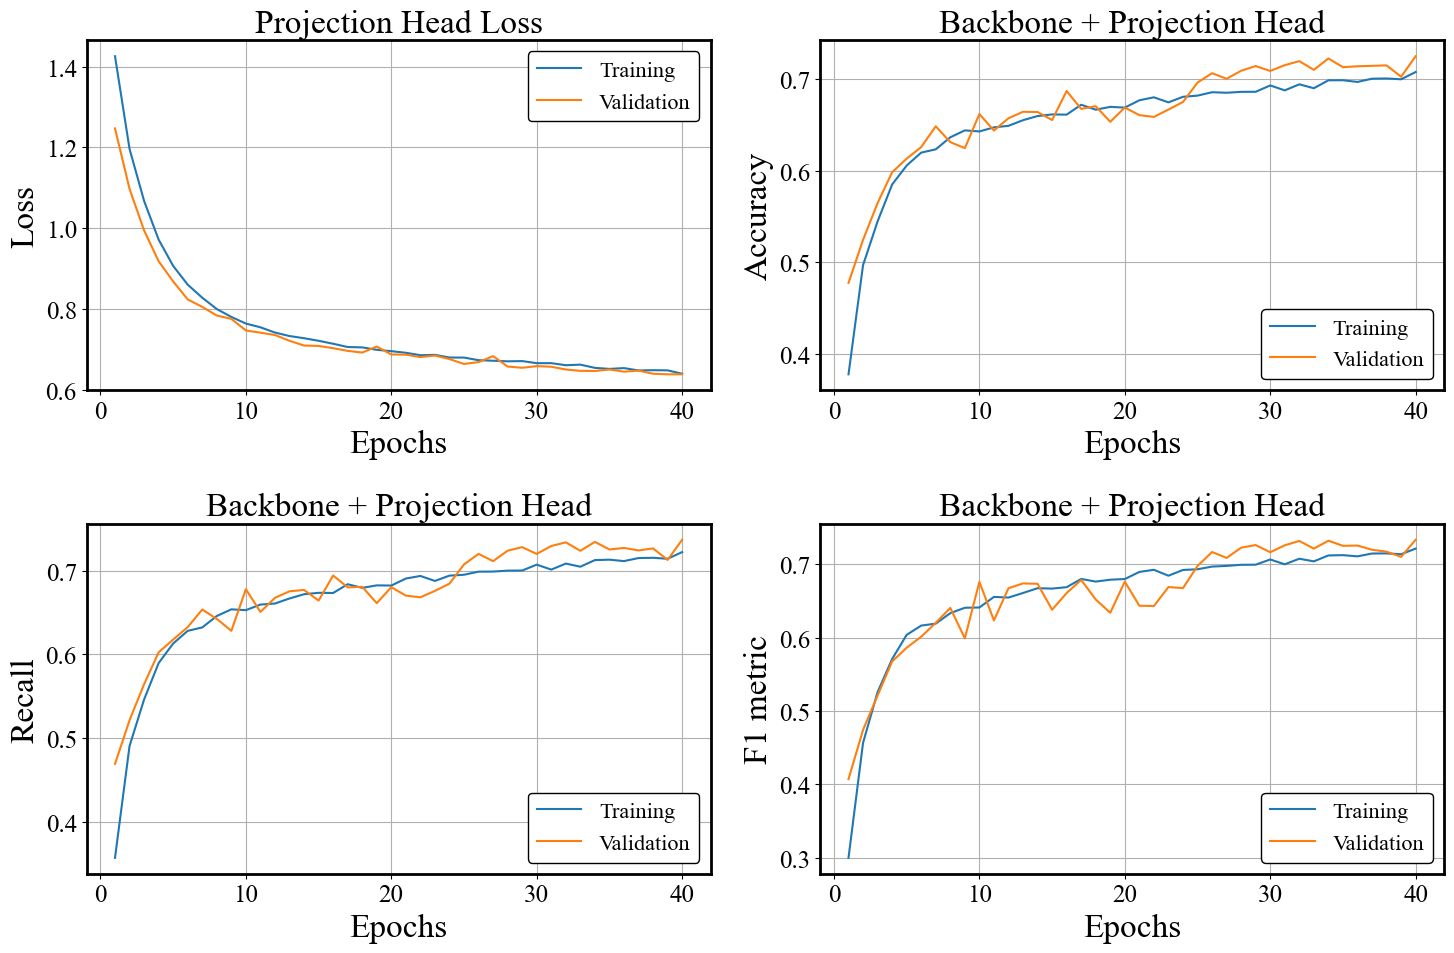

In [54]:
plot_head_metrics(frozen_back_bone_with_proj_head)

## 3.2 Visualizing the Latent Space on the UCI Test Dataset

In [46]:
# Configuring the Test Dataloader
test_dataloader = pretext_datamodule.test_dataloader()

# Visualizing the embedding using t-SNE
time_latents, freq_latents, y_true, y_pred = extract_latent_representations(frozen_back_bone_with_proj_head, test_dataloader,device=device)

In [47]:
label_mapping = {
    0: 'Walking',
    1: 'Walk upstairs',
    2: 'Walk downstairs',
    3: 'Sitting',
    4: 'Standing',
    5: 'Laying'
}

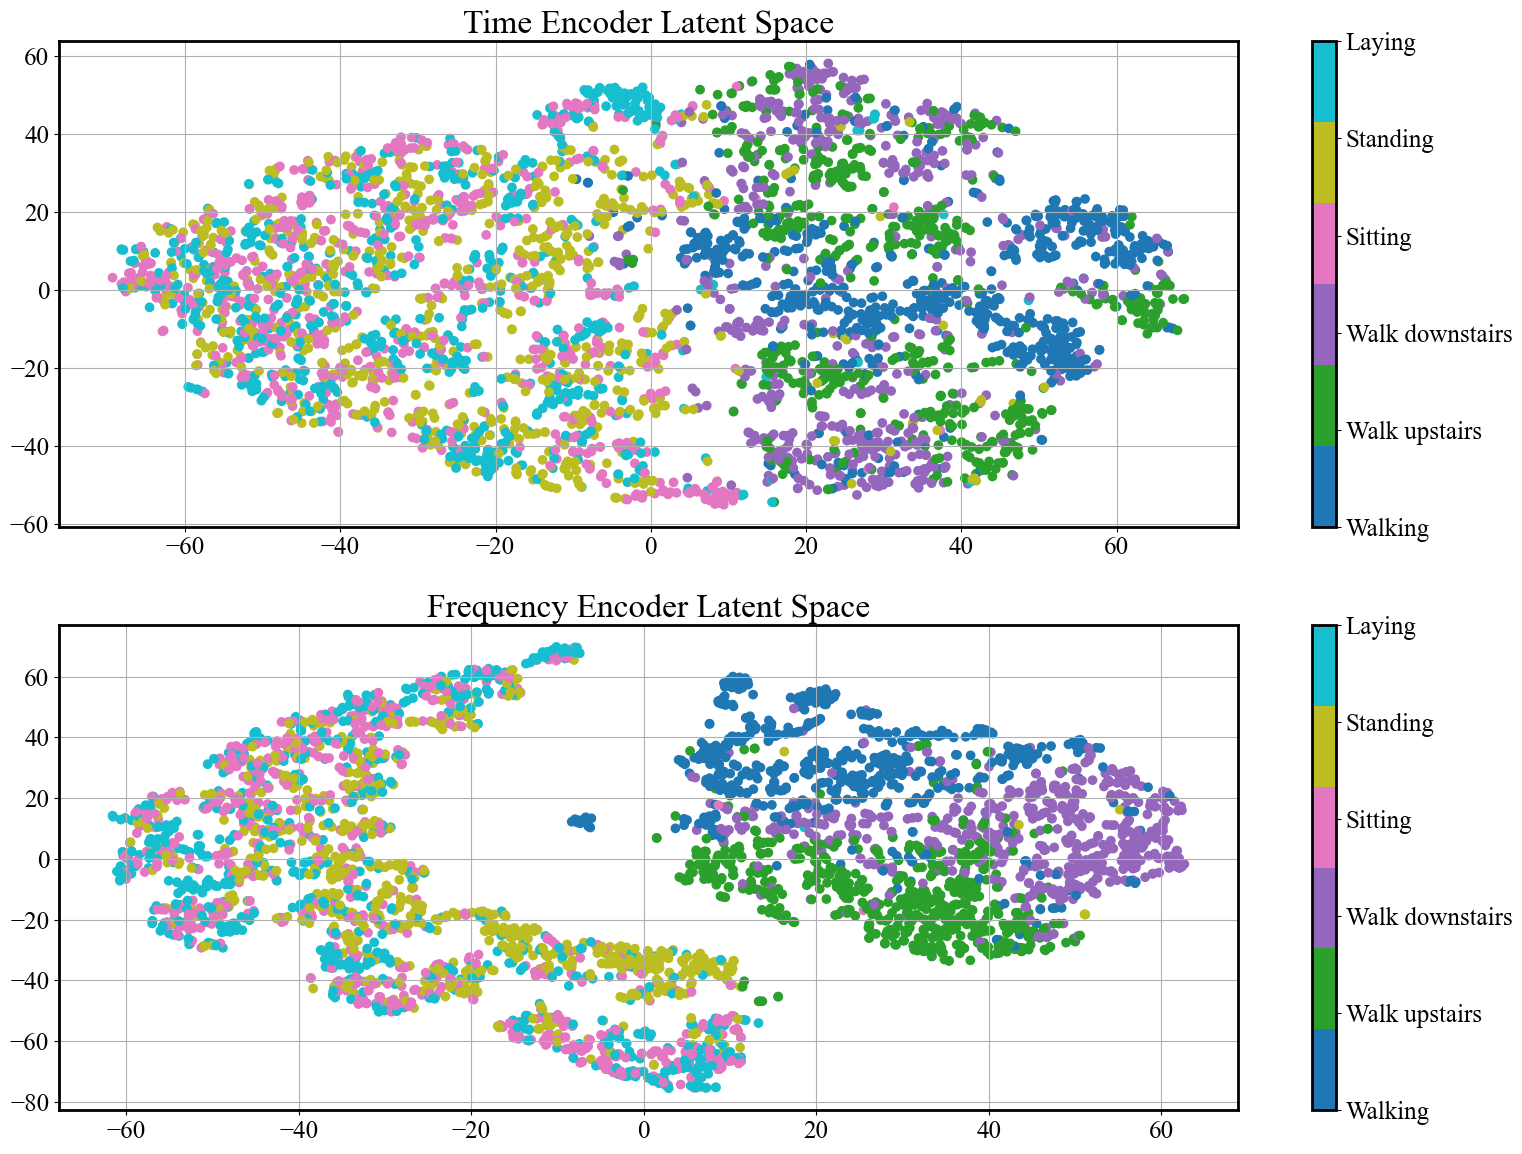

In [48]:
visualize_tsne(time_latents, freq_latents, y_true, label_mapping=label_mapping)

## 3.3 Visualizing the Classification Results 

In [49]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[label_mapping[i] for i in range(len(label_mapping))]))

precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}, F1 Score: {f1:.4f}")

Classification Report:
                 precision    recall  f1-score   support

        Walking       0.90      0.94      0.92       680
  Walk upstairs       0.90      0.91      0.91       616
Walk downstairs       0.90      0.86      0.88       582
        Sitting       0.57      0.47      0.52       746
       Standing       0.55      0.79      0.65       751
         Laying       0.63      0.44      0.52       721

       accuracy                           0.72      4096
      macro avg       0.74      0.74      0.73      4096
   weighted avg       0.73      0.72      0.72      4096

Precision: 0.7279, F1 Score: 0.7178


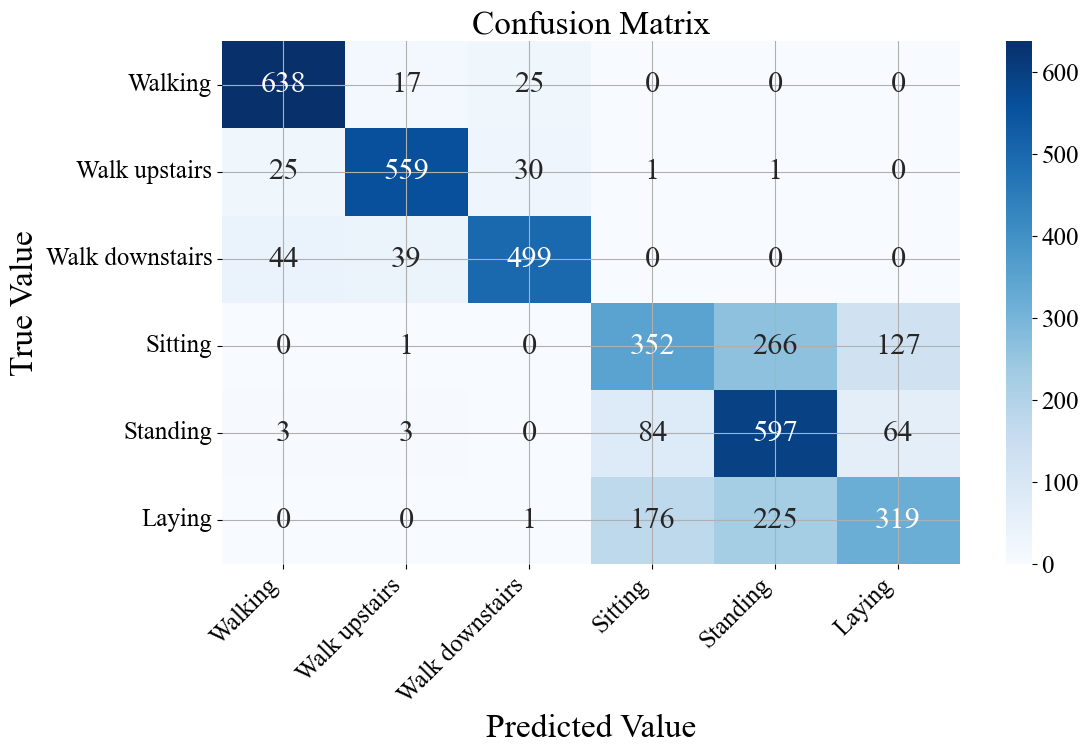

In [50]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred, label_mapping=label_mapping)